# BT3103 Tutorial
## Overview of the education application
* The main task of the application is to help students practice how to write a hypothesis based on the factual evidences presented in a given premise;
* A written hypothesis can be in either one of the three following logical relationship to the given premise
    * Entailment
    * Contradiction
    * Neutral
* The application needs to be able to automatically predict the right relationship between the hypothesis written by the students and the given premise, and return a probability.

Link to the demo education application:
https://nplo4g34yh.execute-api.ap-southeast-1.amazonaws.com/default/textual-entailment-dev

Code repository:
https://github.com/evilkyyyle/textual-entailment-example

## Prerequisites and Environment Setup
* An AWS account
* Install AWS Command Line Interface (AWS CLI)
    * https://docs.aws.amazon.com/comprehend/latest/dg/setup-awscli.html
* Install Docker
    * https://www.docker.com/products/docker-desktop
* Deep Learning Environment
    * Tensorflow, PyTorch, or other learning environment of your choice
    * For this tutorial, we will be using PyTorch (with Python 3.7)

## The NLP Model
In this tutorial, we will use an example NLP model provided by PyTorch. PyTorch examples include a readily-trainable model that is suitable for powering our education application. The model will be trained on the Stanford Natural Language Inference (SNLi) dataset. You can find the example code on:
* https://github.com/pytorch/examples/tree/master/snli 
and the description of the stanford natural language inference (SNLi) dataset on:
* https://nlp.stanford.edu/projects/snli/

## Application Development Pipline
1. Train the NLP model
2. Create the model deployment package (Using Docker)
    * If the package is less than 250MB, direct deployment on AWS Lambda
    * Otherwise, deploy the model on AWS SageMaker (this tutorial)
3. Create the inference (prediction) endpoint
4. Design the serveless application on AWS lambda

## Step 1. Train the NLP Model
Download the example code to your training environment. The training environment could be either your local machine, a remote server, or a cloud service. Deep learning model training will be computational intensive. So we recommend training a remote server or a cloud service. 
For remote server, NUS students could apply for using high-performance computational resource on Singapore National Supercomputing Centre (NSCC). Register your account using the link:
* https://user.nscc.sg
For cloud service, we recommend Google Colaboratory which offer free high-performance GPU resources.
* https://colab.research.google.com
You can explore online to find out more about how to train a model on a remote server or using cloud service, this tutorial will not cover this part in detail. After downloaded the example code along with all required Python packages, you should be able to start model training by simply running the `train.py`.
Before doing the training, we will add one line to the `train.py` to save the vocabulary file for later usage. Add the following line right after **Line 28**. 

In [ ]:
torch.save(inputs.vocab, args.save_path + 'inputs_vocabs.pt')

Model training may take more than 24 hours depending on the computational resources.

## Step 2. Create the Model Deployment Package (with Docker)
The main task in this step is to package all codes necessary into an image that can be directly used to run model inference without any additional setup. All codes necessary are included in the github repository under `project/Sagemaker/container`. This container uses a Python micro web framework called **flask** to manage the model inference. Below is the detailed description of the files included in the container
* `./textual_entailment` the folder that contains the code for make inference (prediction)
    * `./textual_entailment/model.py` copied directly from the PyTorch SNLi example;
    * `./textual_entailment/predictor.py` this is the code that you need to write yourself in order to make inference. This python code should be able to receive an input (the premise and the hypothesis) and output its prediction;
    * you can leave the rest three files `wsgi.py`, `nginx.conf`, and `serve` as it is. They handle the routing logic of the micro web framework
    
The key inference code in `predictor.py` is the **transformation()** function. Inference code is often not directly provided in many open-sourced deep learning model. To wirte the inference code, you need to examine the code structure carefully to understand how the model input data is transformed and how prediction output is organized. 

In [ ]:
@app.route('/invocations', methods=['POST'])
def transformation():
    # Get input JSON data
    input_json = flask.request.get_json()
    json_input = json.dumps(input_json)
    example = data.example.Example.fromJSON(json_input, text_fields)
    example_list = [example]
    # Tokenize data and predict
    if isinstance(text_fields, dict):
        fields, field_dict=[],text_fields
        for field in field_dict.values():
            if isinstance(field, list):
                fields.extend(field)
            else:
                fields.append(field)

    predict = data.dataset.Dataset(examples = example_list, fields = fields)
    predict_iter = data.iterator.Iterator(dataset = predict, batch_size = 1, device=device)
    predict_item = next(iter(predict_iter))
    model.eval()
    answer = model(predict_item)
    xmax = int(torch.max(answer, 1)[1])
    
    # Transform predicted labels (1, 2, and 3) to easier to understand as (Entailment, Contradiction, and Neutral)
    prediction = lambda x: 'Entailment' if x == 1 else ('Contradiction' if
                       x == 2 else 'Neutral')
    label = prediction(xmax)
    percentage = float(torch.exp(answer[0][xmax])/torch.sum(torch.exp(answer)))
    percentage = '{:.2%}'.format(percentage)

    # Transform predictions to JSON
    result = {'label': label, 'probability': percentage}
    result = json.dumps(result)
    return flask.Response(response=result, status=200, mimetype='application/json')

Other files in the `project/Sagemaker/container` directory:
* `./requirements.txt` this file specifies all the required Python libraries for runing the model inference
* `./Dockerfile` this file includes the instructions for Docker to build the deployment image
* `./build_and_push.sh` this is the shell script to run Docker and push the built image to AWS

Before running the shell script, it is important for you to setup AWS CLi first. Follow the AWS documents and make sure that you set the AWS region to **ap-southeast-1** (you can choose whichever region you want, just make sure that everything you upload to AWS is in the same region).

To run the shell script, open terminal (macOS) or command prompt (windows) and change directory to the `container` folder and execute:
`./build_and_push.sh textual_entailment_image`
After running the script, login to your AWS console and direct to ECR service. You should be able to see the image you just uploaded (the Image is around 2GB). **Remmber to save the Image URI elsewhere for later usage.**
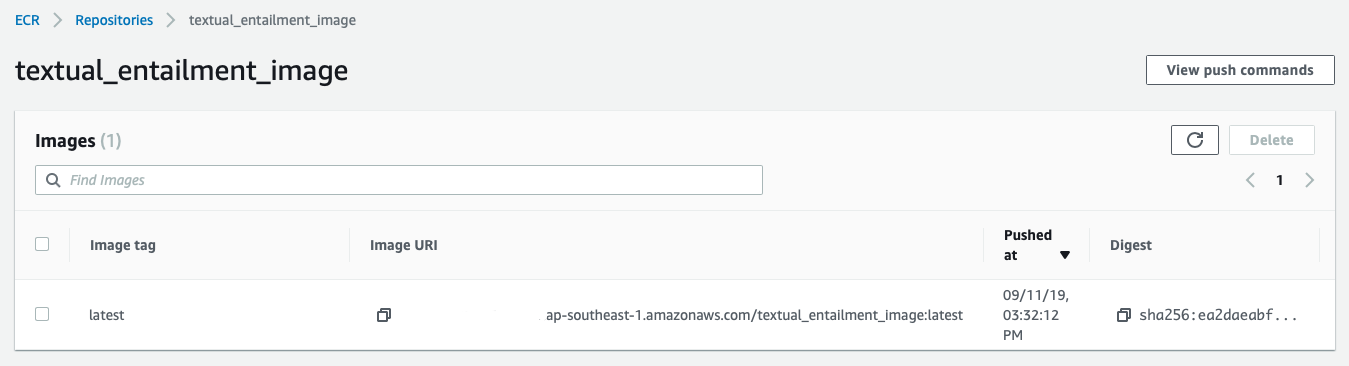

Notice that there is another folder named `local_test` under the `project/Sagemaker/` directory, this is where you can test all you codes locally before push them to AWS. You can find a more detailed tutorial on how to use Docker to  create the deployment package on the link below:
* https://machine-learning-company.nl/deploy-machine-learning-model-rest-api-using-aws/

## Step 3. Create the Inference (Prediction) Endpoint
The endpoint is an API that enable real-time model inference (prediction). Because many deep learning models are often very large (e.g., several millions or billions of weights in deep neural networks), loading the model weights often takes time (from several seconds to several minutes depending on the size of the model). As such, it would not be a good user experience if the application needs to load the model each time before it makes an prediction. The solution is to create a runtime of the model on AWS SageMaker where the model is pre-loaded and ready for fast and real-time prediction. The endpoint provides the interface for the application to communicate with the running model instance. It received the inputs from the application and return the model predictions. What is better is that this setup also allows scalable parallel predictions.

Before creating the endpoint, we need to setup the model in SageMaker. First, we need to upload the model artifacts (i.e., the trained `model.pt` and `inputs_vocabs.pt` files) to AWS S3 bucket. On your AWS web console, create your S3 bucket in the **ap-southeast-1** region and upload the following compressed file to the bucket.
* https://drive.google.com/file/d/15leOvRO9KSloz3z_RyFV7UpaNR0aEN77/view?usp=sharing
(when uploading your own model, remember to compress all files into one `tar.gz` file)
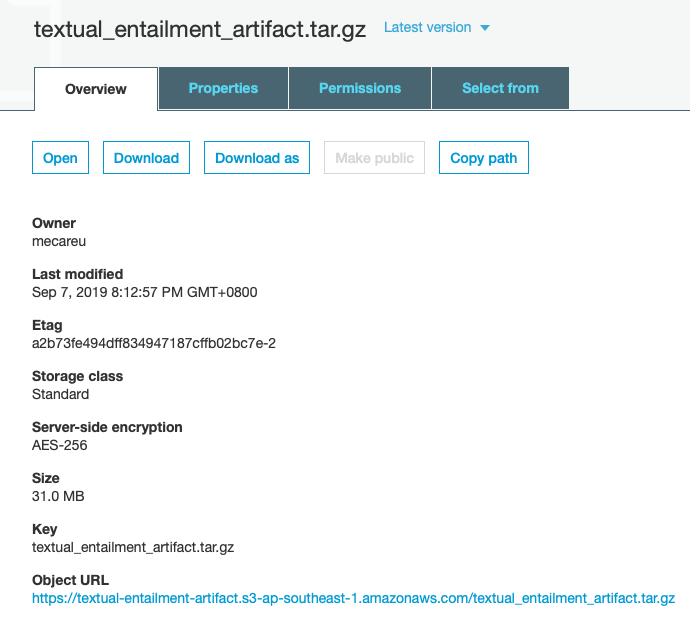
Similarly, **remeber to save the Object URL elsewhere for later usage.** Our model artifacts is around 31MB, but it not uncommon that sometimes the model artifacts could also be several GB.

Now, we can move onto creating the model on SageMaker. Navigate to Amazon SageMaker on the console and find `Models` then `Create Model`. Give your model a name and assign IAM execution role.
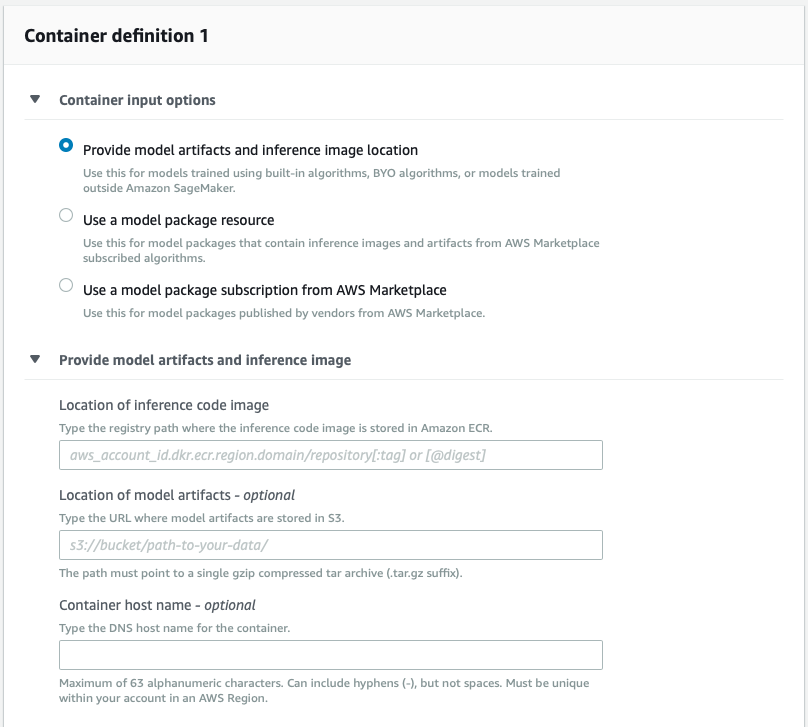
In the container section, put the **Image URI** in **Location of inference code image** and **Object URL** to **Localtion of model artifacts**. Then click **Create model** to finishing creating the model.

With the model in place, we can proceed to creating the endpoint. Navigate to **Endpoint configurations** and choose **Create endpoint configuration**.
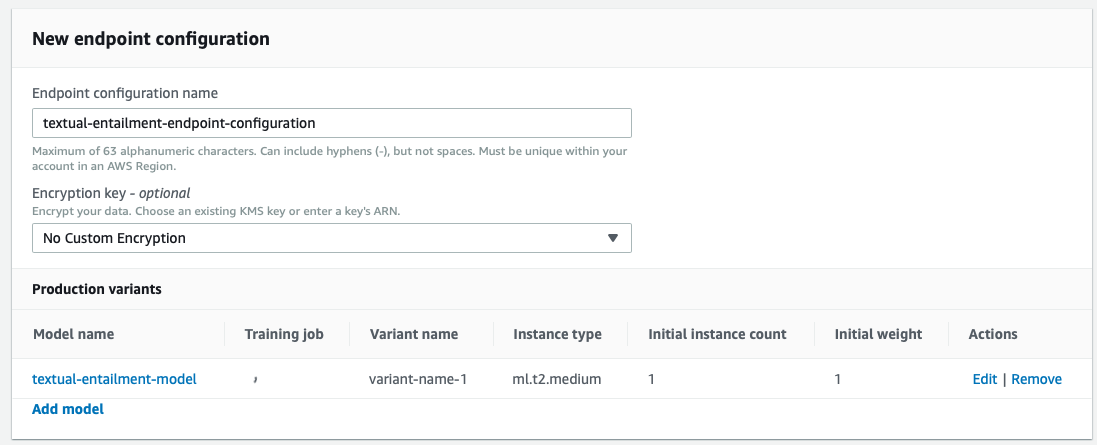
Enter a name for the configuration and add the model we just created. Since our application usage will not be very intensive, we choose the smallest **Instance type** available **ml.t2.medium**. Remember that model runtime on SageMaker costs money. For **ml.t2.medium**, it is around SGD0.08/hour, which should be easliy covered by our AWS Educate program.

At this point, all you need to do is to create the endpoint runtime. Navigate to **Endpoints** and click **Create endpoint**. Then simply select the endpoint configuration we just created. It takes severl minutes for AWS to initiate the endpoint. Once the endpoint status turns to <font color=green>InService</font>, it is ready to be used for model inference. 

## Step 4. Design the Serverless Application on AWS Lambda
It is up to you to decide what is the best way to design the interface and learning path to ensure good user experience for learners. In this tutorial, we will focus more on the technical side of deploying this application on AWS. There are two main technical issue to be considered:
1. Because our application requires a running model instance on AWS SageMaker, we need to handle the connection between SageMaker and Lambda;
2. Because SageMaker runtime is costly, we need to design our application in a way that manage the cost without compromizing user experience.

### Connecting Lambda to SageMaker
In other words, we need to invoke the SageMaker endpoint in the lambda function. To achieve this, you need to give the Lambda IAM role access to SageMaker policy. Navigate to AWS IAM service and find the IAM role you created for your Lambda service. Then choose **Add inline policy**, the following screen should pop up:
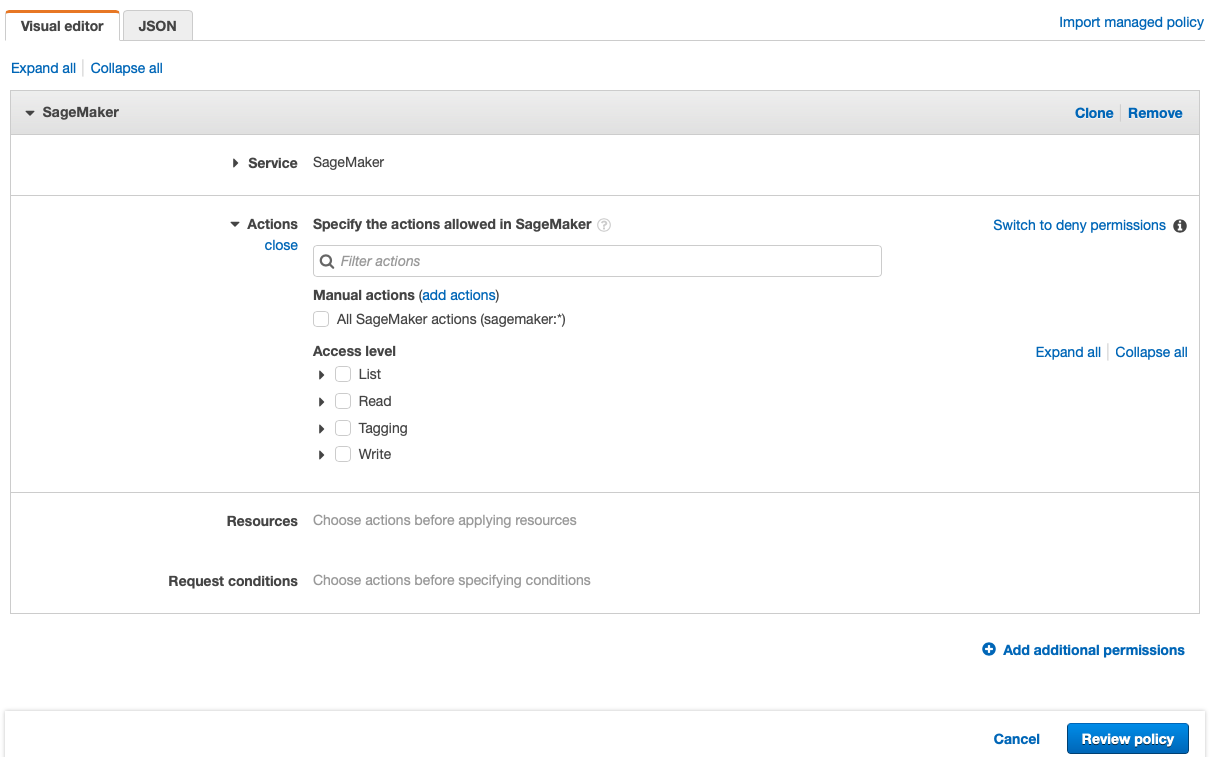
In the policy editor, set the service to SageMaker. In the **Actions** and **Resources** tabs, you can choose the right SageMaker actions and resources your Lambda role has access to. You can simply allow it to have access to all actions and resources. However, it is best for you to find out which actions and resources you need and assign accordingly.
Once the role and policy are updated, you could invoke the SageMaker endpoint in the Lambda function.

In [ ]:
import boto3
runtime_client = boto3.client('runtime.sagemaker')

boto3 is an useful AWS SDK for Python. It allows you to connect to various AWS services using Python code. Check out its documentation at:
* https://boto3.amazonaws.com/v1/documentation/api/latest/index.html?id=docs_gateway

To invoke the created SageMaker endpoint and run prediction, you can write a Python function as:

In [ ]:
def run_prediction(input_json):
    response = runtime_client.invoke_endpoint(
        EndpointName='textual-entailment-endpoint',
        Body=input_json,
        ContentType='application/json',
        Accept='Accept'
    )
    result = response['Body'].read()
    return result.decode('utf-8')

The function takes in an json input and send it to the running model instance on SageMaker, then it fetchs the json format prediction output. Notice that the boto3 function used here is the `runtime.sagemaker.invoke_endpoint`. You cannot use this function if your Lambda IAM role is not setup to access SageMaker. Moreover, if you use only this SageMaker-related function in Lambda, when you are setting up the Lambda role for SageMaker, you would only need to give the role access to SageMaker **Read** action and **invoke_endpoint** resource. Now you can embed this `run_prediction` function in your Lambda Python code to make model prediction. 

### Automatic Initiation and Shutdown of the Endpoint
Since SageMaker runtime incurs cost, we should not keep the endpoint always running in the background unless our application is always being used and generating incomes. As such, to manage SageMaker running cost, we need to setup a mechanism for SageMaker to automatically delete (shutdown) an endpoint when it is not being used. The mechanism being used here is to automatically check every 20 minutes for the SageMaker endpoint status. If it is being idle for more than 40 minutes, then shutdown the endpoint. In this case, only the first user to use this application after a shutdown would need to wait for the initiation of the endpoint (several minutes), a minor compromise to overall user experience.
SageMaker does not provide information on endpoint utilization, it only reports current endpoint status in terms of whether it is running or not. Hence, we can only infer the endpoint idle time by calculating the time lapsed between current time and the last time the endpoint is being invoked. To achieve this, we need a reliable way to log the last endpoint invocation time. In this case, we use AWS **DynamoDB** service along with Lambda temporary storage (dynamoDB needs to be setup separately, and it is very easy). And you need to give your Lambda role access to the **DynamoDB** Actions and Resources.
DynamoDB is a no-SQL database service of AWS. It is free to use if the read/write attempts do not exceed 5 reads or writes per second. Considering that our application could potentially be used by more than 5 users simultaneously, we can avoid this potential overutilization by using it in combination with Lambda temporay storage `/tmp`. The problem with Lambda `/tmp` is that it is not a reliable storage space. Any file stored in `/tmp` may only last for several minutes and could be purged without notice. The following functions works with **DynamoDB** and the `/tmp` storage.

In [ ]:
dynamodb = boto3.client('dynamodb')

# Update the UTC time of Endpoint last invocation 
def update_last_invocation(new_time):
    dynamodb.update_item(
        TableName='GlobalItems',
        Key={'ProjectName':{'S':'textual-entailment'}},
        AttributeUpdates={'lastInvocation':{'Action':'PUT','Value':{'S':new_time}}}
        )
    return

# Get the UTC time when the Endpoint is last invoked
def get_last_invocation():
    item = dynamodb.get_item(
        TableName='GlobalItems',
        Key={'ProjectName':{'S':'textual-entailment'}}
        )
    last_invocation = item['Item']['lastInvocation']['S']
    last_invocation = datetime.strptime(last_invocation, '%Y-%m-%d %H:%M:%S.%f')
    return last_invocation

# Create local log in /tmp directory
def create_log():
    timestamp = str(datetime.utcnow())
    update_last_invocation(timestamp)
    log_text = {
        'lastInvocation': timestamp,
        'lastDynamoUpdate': timestamp
    }
    with open('/tmp/last_invocation.jsonl','w') as f:
        json.dump(log_text, f)
        f.write('\n')
        f.close()
    return

# Update the last invocation in /tmp directory to reduce utilization of DynamoDB
def local_last_invocation(new_time, mode):
    with open('/tmp/last_invocation.jsonl','r') as f:
        invocation_text = json.load(f)
        f.close()
    if mode == 1:
        invocation_text['lastDynamoUpdate'] = new_time
        with open('/tmp/last_invocation.jsonl','w') as f:
            json.dump(invocation_text, f)
            f.write('\n')
            f.close()
        return
    else:
        invocation_text['lastInvocation'] = new_time
        last_update = invocation_text['lastDynamoUpdate']
        invocation_time = datetime.strptime(new_time, '%Y-%m-%d %H:%M:%S.%f')
        update_time = datetime.strptime(last_update, '%Y-%m-%d %H:%M:%S.%f')
        time_diff = (invocation_time-update_time).total_seconds
        with open('/tmp/last_invocation.jsonl','w') as f:
            json.dump(invocation_text, f)
            f.write('\n')
            f.close()
        return time_diff/60

Functions:
* **update_last_invoation()**: update the value of last endpoint invocation time stored in DynamoDB
* **get_last_invoation()**: return the value of last endpoint invocation time stored in DynamoDB
* **create_log()**: create a json file in `/tmp` directory with two values, and update the dynamodb value
    * Time of endpoint last invocation
    * Time of last write to DynamoDB
* **local_last_invoation()**: two mode of update the local json file in `/tmp`
    * Mode 1: update the value of last dynamodb update time in the local file
    * Mode 2: update the value of last endpoint invocation time in the local file and return the minutes elapsed between the current last endpoint invocation time and logged last dynamodb update time

With these four functions, we can rewrite the **run_prediction()** function to allow a reliable logging of endpoint invocation time.

In [ ]:
# Run the prediction and update Endpoint last invocation time
def run_prediction(input_json):
    response = runtime_client.invoke_endpoint(
        EndpointName='textual-entailment-endpoint',
        Body=input_json,
        ContentType='application/json',
        Accept='Accept'
        )
    current_time = str(datetime.utcnow())
    if os.path.isfile('/tmp/last_invocation.jsonl'):
        try:
            minutes_diff = local_last_invocation(current_time, 2)
        except:
            minutes_diff = 0
        if minutes_diff > 5:
            update_last_invocation(current_time)
            local_last_invocation(current_time, 1)
    else:
        create_log()
    result = response['Body'].read()
    return result.decode('utf-8')

Each time the endpoint is invoked, the new function would check first if the local log file in `/tmp` exist or not. If the file exists, update the last endpoint invocation time to the file and get the minutes elapsed to last dynamodb update (If the minutes lapsed is more than 5 minutes, update the dynamodb last endpoint invocation value). If the file does not exist, create a new text file in `/tmp` and update dynamodb with current time. As such, the dynamodb write and read frequency will never exceed the free tier.

With last endpoint invocation time properly logged, we would further use another AWS service **BridgeEvent** to conduct the automatic check for endpoine idle time. Similarly, you need to give your Lambda role access to the **BridgeEvent** Actions and Resources. We define a series of functions to achieve this objective:

In [ ]:
client = boto3.client('sagemaker')
eventWatch = boto3.client('events')

# Check the SageMaker Endpoint status
def get_endpoint_status():
    status = None
    try:
        endpoint_status = client.describe_endpoint(
            EndpointName='textual-entailment-endpoint'
            )
        status = endpoint_status['EndpointStatus']
    except:
        status = "notExist"
    return status

# Initiate the SageMaker Endpoint
def initiate_endpoint():
    client.create_endpoint(
        EndpointName='textual-entailment-endpoint',
        EndpointConfigName='textual-entailment-endpoint-configuration'
        )
    return
    
# Delete the SageMaker Endpoint
def terminate_endpoint():
    client.delete_endpoint(
        EndpointName='textual-entailment-endpoint'
        )
    return

# Check the time elapsed between current UTC time and Endpoint last invocation time
def check_time_interval():
    current_time = datetime.utcnow()
    last_invocation = get_last_invocation()
    time_diff = (current_time - last_invocation).total_seconds()
    return time_diff/60

Functions:
* **get_endpoint_status()**: return the endpoint status. If no endpoint, return **notExist**
* **initiate_endpoint()**: create the endpoint using existing configuration
* **terminate_endpoint()**: terminate (delete) the endpoint
* **check_time_interval()**: return the minutes elapsed between the last endpoint invocation time stored in dynamodb and current time. 

Navigate your AWS console to **CloudWatch**. Under **Rules**, choose **Create rule**. Setup the rule as shown below:
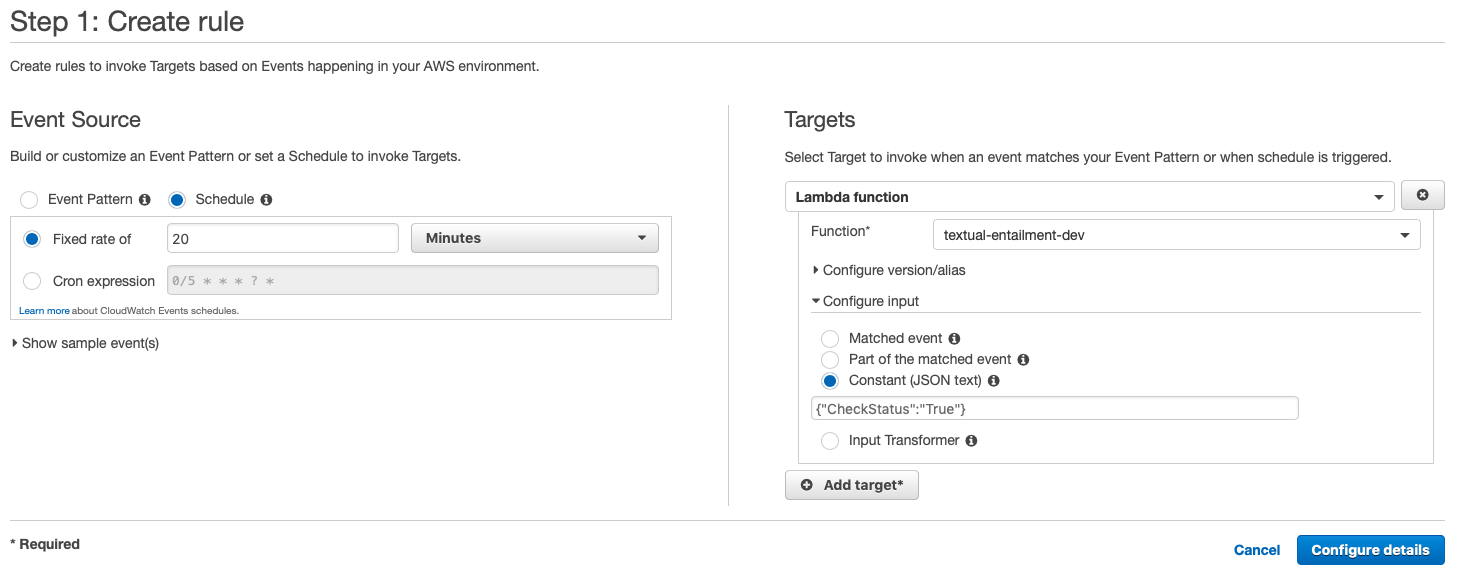
The event scheduler will now invoke the Lambda Function every 20 minutes once enabled and pass it the json text **{"CheckStatus":"True"}**.

Now add the following codes to your Lambda function before loading the html page:

In [ ]:
status = get_endpoint_status()

# If at the time of scheduled checking, time elapsed is more than 40 minutes, then delete the Endpoint.
if "CheckStatus" in event and event["CheckStatus"]:
    time_interval = check_time_interval()
    if time_interval > 40 and status == 'InService':
        terminate_endpoint()
        # Terminate the CloudWatch Event as well
        eventWatch.disable_rule(
            Name="CheckStatus"
            )
    return {
    "statusCode": 200
    }

# If no Endpoint instance is running, proceed to create the Endpoint
if status == "notExist":
    initiate_endpoint()
    create_log()
    # Enable the CloudWatch Event for automatic Endpoint shutdown
    eventWatch.enable_rule(
        Name="CheckStatus"
        )

If the Lambda function is invoked not by the users but the scheduled event, it will receive the **"CheckStatus"** message and check the minutes elapsed between current time and last endpoint invocation time logged in dynamodb. If minutes elapased is more than 40 minutes, shut down the endpoint and disable the CloudWatch events. After the check, it will also terminate the execution of the Lambda function.

If the Lambda function is invoked by the user, it will check whether the endpoint exists or not. If not, it will create the endpoint, create a local json log file in `/tmp`, and enable the CloudWatch events.